# Kaggle Study 5일차(타이타닉)

코드출처 : https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

## 1 회차

## Introduction

이 노트북은 기본 학습 모델, 특히 Stacking으로 알려진 앙상블의 변형 모델을 결합(결합)하는 방법에 대한 매우 기본적이고 간단한 입문 내용이다. 몇 가지 기본 분류기의 예측이 첫 번째 수준(베이스)으로 사용된 다음 두 번째 수준의 다른 모델을 사용하여 이전 첫 번째 수준 예측의 출력을 예측한다.

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

## Feature Exploration, Engineering and Cleaning

먼저 데이터를 탐색하고, 가능한 모든 feature engineering을 식별한 뒤 모든 범주적 특징을 수치적으로 인코딩할 것이다.

In [2]:
train = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/titanic/train.csv')
test = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/titanic/test.csv')

PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train,test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x)==float else 1)

for dataset in full_data:
    dataset["FamilySize"] = dataset["Parch"] + dataset["SibSp"] + 1

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
for dataset in full_data:
    dataset["Fare"] = dataset["Fare"].fillna(train['Fare'].median())

train['CategoricalFare'] = pd.qcut(train['Fare'],4)

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg-age_std, age_avg+age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.qcut(train['Age'],5)

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.',name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')
    
#data mapping
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map({'female':0,'male':1}).astype(int)
    
    title_mapping={'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Rare':5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset['Embarked'] = dataset['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
    
    dataset.loc[dataset['Fare']<=7.91,'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[dataset['Age']<=16,'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age']>64,'Age'] = 4

In [4]:
drop_elements = ['PassengerId','Name','Ticket','Cabin','SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge','CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)

- 이제 기능을 정리하고 관련 정보를 추출하고 범주 열을 삭제했으므로 이제 기능이 모두 기계 학습 모델에 적합한 형식인 숫자여야 한다. 

- 일단 변환된 데이터 세트의 몇 가지 간단한 상관 관계 및 분포도를 생성해보기로 한다.

## Visualisation

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


### 피어슨 상관관계 히트맵(Pearson Correlation Heatmap)

상관분포도를 생성하여 한 feature가 다음 feature과 얼마나 관련이 있는지 확인해보도록 한다. 이를 위해 Seaborn Plotting 패키지를 활용하여 다음과 같이 히트맵을 매우 편리하게 플로팅할 수 있도록 하겠습니다.

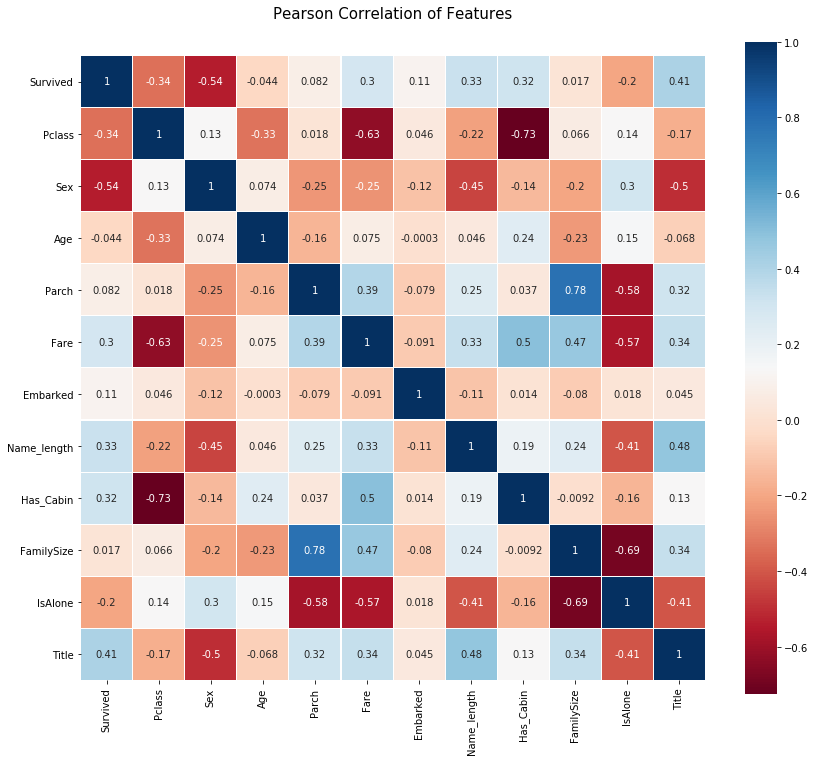

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)

- 피어슨 상관 관계도를 통해 알 수 있는 한 가지 사실은 서로 강한 상관 관계가 있는 형상이 그리 많지 않다는 것이다.

- 이는 교육 세트에 중복되거나 불필요한 데이터가 많지 않다는 것을 의미하며 각 기능이 고유한 정보를 제공하므로 이러한 기능을 학습 모델에 제공하는 관점에서 유용합니다. 

- 다음은 가족 크기(FamilySize)와 Parch(부모와 자녀)의 가장 상관된 두 가지 기능입니다. 이 연습의 목적을 위해 두 가지 기능을 모두 그대로 두겠습니다.

### Pairplots

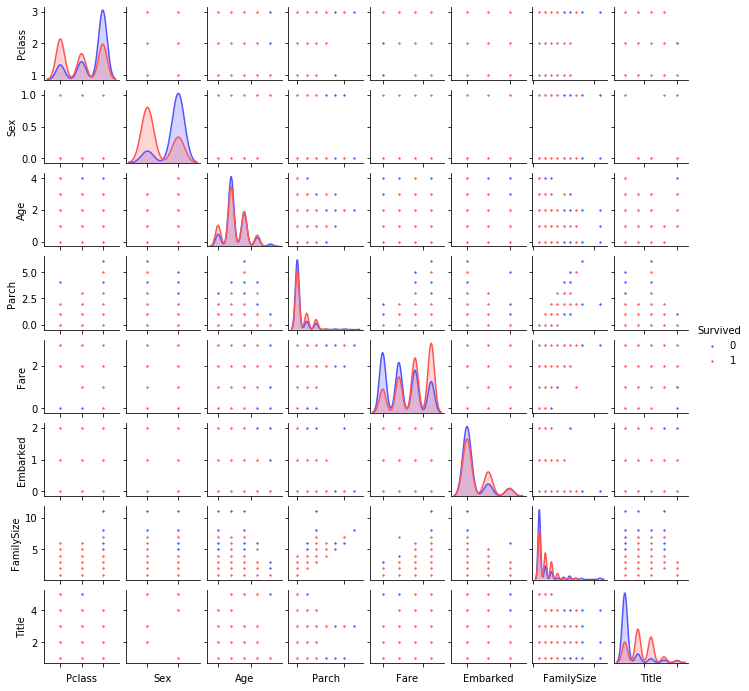

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws={'bw':0.2},plot_kws=dict(s=10) )
g.set(xticklabels=[])

## Ensembling & Stacking models

In [8]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits = NFOLDS, random_state = SEED,shuffle=True)

class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

- 클래스의 기본 생성자를 호출하기 위한 Python 표준입니다. 즉, 개체(분류기)를 생성하려면 clf(원하는 sklearn 분류기), 시드(랜덤 시드) 및 매개 변수(분류기에 대한 매개 변수)의 매개 변수를 지정해야 한다.

- 나머지 코드는 단순히 sklearn 분류기 내에 이미 존재하는 해당 메소드를 호출하는 클래스의 메소드이다. 본질적으로, 우리는 다양한 Sklearn 분류기를 확장하기 위해 래퍼 클래스를 만들어 여러 학습자를 우리의 스토커에 구현할 때 동일한 코드를 반복적으로 작성해야 하는 것을 줄일 수 있다.

### Out-of-Fold Prediction

- Stacking은 second-level 모델에 대한 교육을 위한 입력으로 기본 분류기의 예측을 사용한다. 

- 그러나 단순히 전체 훈련 데이터에 대한 기본 모델을 교육하고, 전체 테스트 세트에 대한 예측을 생성한 다음, 두 번째 레벨 훈련을 위해 이러한 모델을 출력할 수는 없다. 이렇게 하면 기본 모형 예측이 이미 검정 집합을 "본" 경우 이러한 예측을 제공할 때 과대 적합될 위험이 있습니다.

In [9]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models
1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifer
4. Gradient Boosting classifer
5. Support Vector Machine

### Parameters

- n_jobs : 교육 프로세스에 사용되는 코어 수. -1로 설정하면 모든 코어가 사용e된다.

- n_estimators : 학습 모델의 분류 트리 수(기본값당 10개로 설정)

- max_depth : 트리의 최대 깊이 또는 노드를 확장해야 하는 양. 너무 높게 설정하면 나무를 너무 깊이 기를 수 있으므로 과적합 위험이 발생할 수 있으므로 주의해야 한다.

- vervose: 학습 프로세스 중에 텍스트를 출력할지 여부를 제어. 값이 0이면 모든 텍스트가 억제되고 값이 3이면 모든 반복에서 트리 학습 프로세스가 출력된다.

In [10]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [11]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### Creating NumPy arrays out of our train and test sets

- 우리는 Sklearn 모델의 매우 미세한 특징을 활용할 수 있으며, 간단한 코드 라인으로 훈련과 테스트 세트의 feature importance을 출력하는 것이다.

- Sklearn 설명서에 따라 대부분의 분류기는 .featureimportance를 입력하기만 하면 기능 중요성을 반환하는 속성을 내장하고 있다. 따라서 우리는 우리의 함수 얼리어를 통해 매우 유용한 이 속성을 호출하고, 이와 같은 특징의 중요성을 표시할 것이다.

In [12]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'],axis=1)
x_train = train.values
x_test = test.values

### Output of the First level Predictions

In [13]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


### Feature importances generated from the different classifiers

In [14]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.10274306 0.2095722  0.03495514 0.01945139 0.0479711  0.0283753
 0.12856998 0.04862095 0.07306275 0.01166919 0.29500893]
[0.12023907 0.37785339 0.02885043 0.01664137 0.05560508 0.02821027
 0.04798488 0.08491843 0.04312227 0.02233725 0.17423756]
[0.03  0.012 0.016 0.068 0.036 0.01  0.702 0.012 0.052 0.002 0.06 ]
[0.0870806  0.01134213 0.04807703 0.01198437 0.05130097 0.02705568
 0.17826579 0.03784768 0.11115264 0.00495597 0.43093713]


In [15]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854 ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

In [16]:
cols = train.columns.values

feature_dataframe = pd.DataFrame({'features':cols,
                                 'Random Forest feature importances': rf_features,
                                 'Extra Trees feature importances': et_features,
                                 'AdaBoost feature importances': ada_features,
                                 'Gradient Boost feature importances': gb_features,})

### Interactive feature importances via Plotly scatterplots

In [17]:
#RandomForest
trace = go.Scatter(y=feature_dataframe['Random Forest feature importances'].values,
                  x = feature_dataframe['features'].values,
                  mode='markers',
                  marker=dict(sizemode = 'diameter',
                             sizeref = 1,
                             size = 25,
                             color = feature_dataframe['Random Forest feature importances'].values,
                            #size= feature_dataframe['AdaBoost feature importances'].values,
                            #color = np.random.randn(500), #set color equal to a variable
                             colorscale = 'Portland',
                             showscale = True),
                  text = feature_dataframe['features'].values)
data = [trace]
layout = go.Layout(autosize=True,
                  title = 'Random Forest Feature Importance',
                  hovermode = 'closest',
                # xaxis= dict(
                #      title= 'Pop',
                #      ticklen= 5,
                #      zeroline= False,
                #      gridwidth= 2,
                #     ),
                  yaxis= dict(
                      title= 'Feature Importance',
                      ticklen= 5,
                      gridwidth= 2),
                  showlegend = False)
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatter2010')

#Extra Trees
trace = go.Scatter(y=feature_dataframe['Extra Trees feature importances'].values,
                  x = feature_dataframe['features'].values,
                  mode='markers',
                  marker=dict(sizemode = 'diameter',
                             sizeref = 1,
                             size = 25,
                             color = feature_dataframe['Extra Trees feature importances'].values,
                            #size= feature_dataframe['AdaBoost feature importances'].values,
                            #color = np.random.randn(500), #set color equal to a variable
                             colorscale = 'Portland',
                             showscale = True),
                  text = feature_dataframe['features'].values)
data = [trace]
layout = go.Layout(autosize=True,
                  title = 'Extra Trees Feature Importance',
                  hovermode = 'closest',
                # xaxis= dict(
                #      title= 'Pop',
                #      ticklen= 5,
                #      zeroline= False,
                #      gridwidth= 2,
                #     ),
                  yaxis= dict(
                      title= 'Feature Importance',
                      ticklen= 5,
                      gridwidth= 2),
                  showlegend = False)
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatter2010')

#AdaBoost Trees
trace = go.Scatter(y=feature_dataframe['AdaBoost feature importances'].values,
                  x = feature_dataframe['features'].values,
                  mode='markers',
                  marker=dict(sizemode = 'diameter',
                             sizeref = 1,
                             size = 25,
                             color = feature_dataframe['AdaBoost feature importances'].values,
                            #size= feature_dataframe['AdaBoost feature importances'].values,
                            #color = np.random.randn(500), #set color equal to a variable
                             colorscale = 'Portland',
                             showscale = True),
                  text = feature_dataframe['features'].values)
data = [trace]
layout = go.Layout(autosize=True,
                  title = 'AdaBoost Feature Importance',
                  hovermode = 'closest',
                # xaxis= dict(
                #      title= 'Pop',
                #      ticklen= 5,
                #      zeroline= False,
                #      gridwidth= 2,
                #     ),
                  yaxis= dict(
                      title= 'Feature Importance',
                      ticklen= 5,
                      gridwidth= 2),
                  showlegend = False)
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatter2010')


#Gradient Boost
trace = go.Scatter(y=feature_dataframe['Gradient Boost feature importances'].values,
                  x = feature_dataframe['features'].values,
                  mode='markers',
                  marker=dict(sizemode = 'diameter',
                             sizeref = 1,
                             size = 25,
                             color = feature_dataframe['Gradient Boost feature importances'].values,
                            #size= feature_dataframe['AdaBoost feature importances'].values,
                            #color = np.random.randn(500), #set color equal to a variable
                             colorscale = 'Portland',
                             showscale = True),
                  text = feature_dataframe['features'].values)
data = [trace]
layout = go.Layout(autosize=True,
                  title = 'Gradient Boost Feature Importance',
                  hovermode = 'closest',
                # xaxis= dict(
                #      title= 'Pop',
                #      ticklen= 5,
                #      zeroline= False,
                #      gridwidth= 2,
                #     ),
                  yaxis= dict(
                      title= 'Feature Importance',
                      ticklen= 5,
                      gridwidth= 2),
                  showlegend = False)
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatter2010')

In [18]:
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104741,0.121657,0.028,0.067961,0.080590
1,Sex,0.218370,0.370983,0.008,0.038893,0.159062
2,Age,0.044327,0.031296,0.012,0.072378,0.040000


In [19]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

### Second-Level Predictions from the First-level Output

#### First-level 출력을 새로운 Feature로 사용

이제 우리의 첫 번째 수준 예측을 얻었으므로, 우리는 그것을 다음 분류기의 훈련 데이터로 사용할 수 있다는 것을 생각할 수 있다.  
따라서 아래 코드에 따라, 우리는 이전 분류기의 첫 번째 수준 예측을 새로운 열로 가지고 있으며 이에 대한 다음 분류기를 훈련시킨다.

In [20]:
base_predictions_train = pd.DataFrame({'RandomForest':rf_oof_train.ravel(),
                                       'ExtraTrees':et_oof_train.ravel(),
                                       'AdaBoost':ada_oof_train.ravel(),
                                      'GradientBoost':gb_oof_train.ravel(),})

base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


#### Correlation Heatmap of the Second Level Training set

In [21]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')


- 서로 상관없는 훈련된 모델이 더 좋은 점수를 얻을 수 있다는 것에 대한 기사들과 Kaggle 대회 우승자들의 이야기는 꽤 많이 있었다.

In [22]:
X_train = np.concatenate((et_oof_train,rf_oof_train,ada_oof_train,gb_oof_train,svc_oof_train),axis=1)
X_test = np.concatenate((et_oof_test,rf_oof_test,ada_oof_test,gb_oof_test,svc_oof_test),axis=1)

- 이제 첫 번째 레벨 열차와 테스트 예측 모두를 x_train 및 x_test로 연결하고 결합했으므로 이제 두 번째 레벨 학습 모델을 적합시킬 수 있다.

#### Second level learning model via XGBoost

- second-level학습에서는 강화 트리 학습 모델인 XGBoost를 선택한다. XGBoost는 대규모 부스트 트리 알고리즘을 최적화하기 위해 제작되었다.

- XGB 분류기를 호출하여 이를 첫 번째 수준의 열차와 대상 데이터에 적합시키고 학습된 모델을 사용하여 다음과 같이 테스트 데이터를 예측한다.

In [23]:
gbm = xgb.XGBClassifier(n_estimators=2000,
                       max_depth = 4,
                       min_child_weight=2,
                       gamma=0.9,
                       subsample=0.8,
                       colsample_bytree=0.8,
                       objective='binary:logistic',
                       nthread=-1,
                       scale_pos_weight=1).fit(x_train,y_train)
predictions = gbm.predict(x_test)

[XGBoost 매개 변수]

- max_depth: 트리를 얼마나 깊이 키우고 싶은가. 너무 높게 설정하면 과적합 위험이 있을 수 있으므로 주의하십시오.

- gamma : 트리의 리프 노드에서 추가 파티션을 만드는 데 필요한 최소 손실 감소. 크기가 클수록 알고리즘의 보수성이 높아집니다.

- eta: 과적합을 방지하기 위해 각 부스팅 단계에서 사용되는 스텝 크기 축소

## Producing the Submission file

In [24]:
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

## 2회차

## Introduction

이 노트북은 기본 학습 모델, 특히 Stacking으로 알려진 앙상블의 변형 모델을 결합(결합)하는 방법에 대한 매우 기본적이고 간단한 입문 내용이다. 몇 가지 기본 분류기의 예측이 첫 번째 수준(베이스)으로 사용된 다음 두 번째 수준의 다른 모델을 사용하여 이전 첫 번째 수준 예측의 출력을 예측한다.

In [25]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

## Feature Exploration, Engineering and Cleaning

먼저 데이터를 탐색하고, 가능한 모든 feature engineering을 식별한 뒤 모든 범주적 특징을 수치적으로 인코딩할 것이다.

In [26]:
train = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/titanic/train.csv')
test = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/titanic/test.csv')

PassengerId = test["PassengerId"]

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [27]:
full_data = [train,test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x)==float else 1)

for dataset in full_data:
    dataset["FamilySize"] = dataset["Parch"] + dataset["SibSp"] + 1

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
for dataset in full_data:
    dataset["Fare"] = dataset["Fare"].fillna(train['Fare'].median())

train['CategoricalFare'] = pd.qcut(train['Fare'],4)

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg-age_std, age_avg+age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.qcut(train['Age'],5)

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.',name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')
    
#data mapping
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map({'female':0,'male':1}).astype(int)
    
    title_mapping={'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Rare':5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset['Embarked'] = dataset['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
    
    dataset.loc[dataset['Fare']<=7.91,'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[dataset['Age']<=16,'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age']>64,'Age'] = 4

In [28]:
drop_elements = ['PassengerId','Name','Ticket','Cabin','SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge','CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)

- 이제 기능을 정리하고 관련 정보를 추출하고 범주 열을 삭제했으므로 이제 기능이 모두 기계 학습 모델에 적합한 형식인 숫자여야 한다. 

- 일단 변환된 데이터 세트의 몇 가지 간단한 상관 관계 및 분포도를 생성해보기로 한다.

## Visualisation

In [29]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


### 피어슨 상관관계 히트맵(Pearson Correlation Heatmap)

상관분포도를 생성하여 한 feature가 다음 feature과 얼마나 관련이 있는지 확인해보도록 한다. 이를 위해 Seaborn Plotting 패키지를 활용하여 다음과 같이 히트맵을 매우 편리하게 플로팅할 수 있도록 하겠습니다.

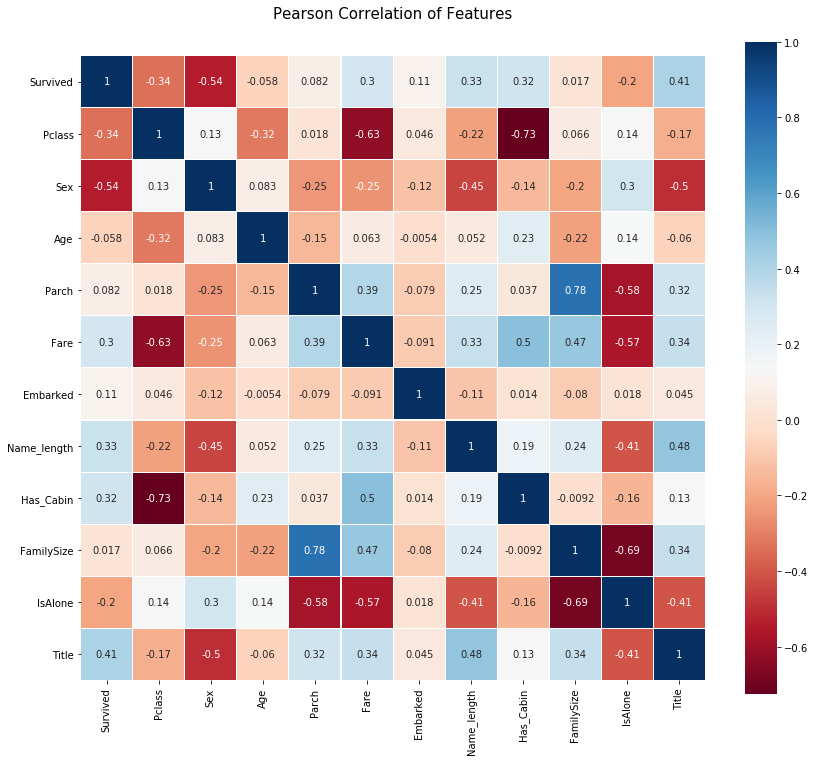

In [30]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)

- 피어슨 상관 관계도를 통해 알 수 있는 한 가지 사실은 서로 강한 상관 관계가 있는 형상이 그리 많지 않다는 것이다.

- 이는 교육 세트에 중복되거나 불필요한 데이터가 많지 않다는 것을 의미하며 각 기능이 고유한 정보를 제공하므로 이러한 기능을 학습 모델에 제공하는 관점에서 유용합니다. 

- 다음은 가족 크기(FamilySize)와 Parch(부모와 자녀)의 가장 상관된 두 가지 기능입니다. 이 연습의 목적을 위해 두 가지 기능을 모두 그대로 두겠습니다.

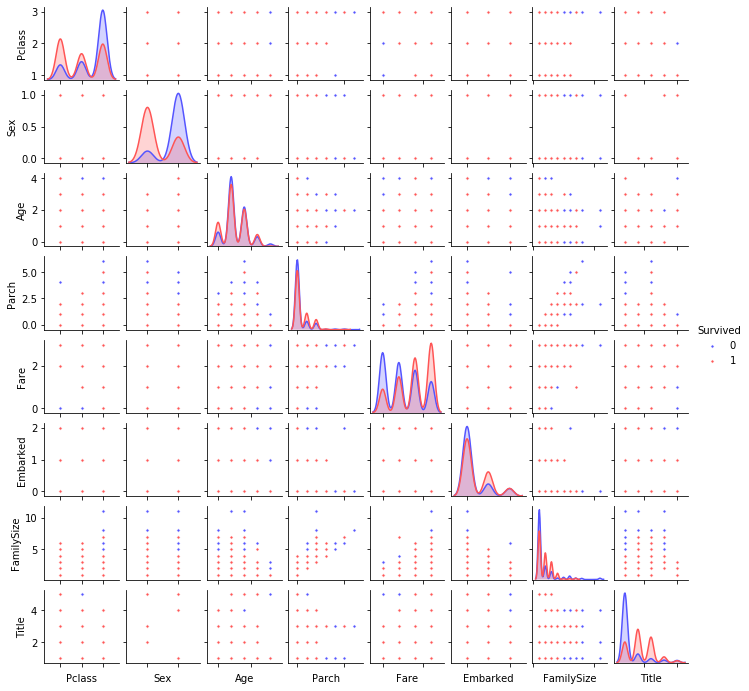

In [31]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws={'bw':0.2},plot_kws=dict(s=10) )
g.set(xticklabels=[])

## Ensembling & Stacking models

In [32]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits = NFOLDS, random_state = SEED,shuffle=True)

class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

- 클래스의 기본 생성자를 호출하기 위한 Python 표준입니다. 즉, 개체(분류기)를 생성하려면 clf(원하는 sklearn 분류기), 시드(랜덤 시드) 및 매개 변수(분류기에 대한 매개 변수)의 매개 변수를 지정해야 한다.

- 나머지 코드는 단순히 sklearn 분류기 내에 이미 존재하는 해당 메소드를 호출하는 클래스의 메소드이다. 본질적으로, 우리는 다양한 Sklearn 분류기를 확장하기 위해 래퍼 클래스를 만들어 여러 학습자를 우리의 스토커에 구현할 때 동일한 코드를 반복적으로 작성해야 하는 것을 줄일 수 있다.

### Out-of-Fold Prediction

- Stacking은 second-level 모델에 대한 교육을 위한 입력으로 기본 분류기의 예측을 사용한다. 

- 그러나 단순히 전체 훈련 데이터에 대한 기본 모델을 교육하고, 전체 테스트 세트에 대한 예측을 생성한 다음, 두 번째 레벨 훈련을 위해 이러한 모델을 출력할 수는 없다. 이렇게 하면 기본 모형 예측이 이미 검정 집합을 "본" 경우 이러한 예측을 제공할 때 과대 적합될 위험이 있습니다.

In [33]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models
1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifer
4. Gradient Boosting classifer
5. Support Vector Machine

### Parameters

- n_jobs : 교육 프로세스에 사용되는 코어 수. -1로 설정하면 모든 코어가 사용e된다.

- n_estimators : 학습 모델의 분류 트리 수(기본값당 10개로 설정)

- max_depth : 트리의 최대 깊이 또는 노드를 확장해야 하는 양. 너무 높게 설정하면 나무를 너무 깊이 기를 수 있으므로 과적합 위험이 발생할 수 있으므로 주의해야 한다.

- vervose: 학습 프로세스 중에 텍스트를 출력할지 여부를 제어. 값이 0이면 모든 텍스트가 억제되고 값이 3이면 모든 반복에서 트리 학습 프로세스가 출력된다.

In [34]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [35]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### Creating NumPy arrays out of our train and test sets

- 우리는 Sklearn 모델의 매우 미세한 특징을 활용할 수 있으며, 간단한 코드 라인으로 훈련과 테스트 세트의 feature importance을 출력하는 것이다.

- Sklearn 설명서에 따라 대부분의 분류기는 .featureimportance를 입력하기만 하면 기능 중요성을 반환하는 속성을 내장하고 있다. 따라서 우리는 우리의 함수 얼리어를 통해 매우 유용한 이 속성을 호출하고, 이와 같은 특징의 중요성을 표시할 것이다.

In [36]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'],axis=1)
x_train = train.values
x_test = test.values

### Output of the First level Predictions

In [37]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


### Feature importances generated from the different classifiers

In [38]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.10222806 0.20966655 0.03292702 0.0201206  0.04776687 0.02798184
 0.1289599  0.0489806  0.07345603 0.01158286 0.29632968]
[0.11939669 0.37897834 0.02861408 0.01716889 0.05646044 0.02857124
 0.04763714 0.08450015 0.04331933 0.02133901 0.17401469]
[0.03  0.012 0.014 0.064 0.038 0.008 0.704 0.012 0.048 0.002 0.068]
[0.0862314  0.01375733 0.05358857 0.01247181 0.04575037 0.02446801
 0.17685394 0.03903184 0.1110226  0.00664876 0.43017537]


In [39]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854 ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

In [40]:
cols = train.columns.values

feature_dataframe = pd.DataFrame({'features':cols,
                                 'Random Forest feature importances': rf_features,
                                 'Extra Trees feature importances': et_features,
                                 'AdaBoost feature importances': ada_features,
                                 'Gradient Boost feature importances': gb_features,})

### Interactive feature importances via Plotly scatterplots

In [41]:
#RandomForest
trace = go.Scatter(y=feature_dataframe['Random Forest feature importances'].values,
                  x = feature_dataframe['features'].values,
                  mode='markers',
                  marker=dict(sizemode = 'diameter',
                             sizeref = 1,
                             size = 25,
                             color = feature_dataframe['Random Forest feature importances'].values,
                            #size= feature_dataframe['AdaBoost feature importances'].values,
                            #color = np.random.randn(500), #set color equal to a variable
                             colorscale = 'Portland',
                             showscale = True),
                  text = feature_dataframe['features'].values)
data = [trace]
layout = go.Layout(autosize=True,
                  title = 'Random Forest Feature Importance',
                  hovermode = 'closest',
                # xaxis= dict(
                #      title= 'Pop',
                #      ticklen= 5,
                #      zeroline= False,
                #      gridwidth= 2,
                #     ),
                  yaxis= dict(
                      title= 'Feature Importance',
                      ticklen= 5,
                      gridwidth= 2),
                  showlegend = False)
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatter2010')

#Extra Trees
trace = go.Scatter(y=feature_dataframe['Extra Trees feature importances'].values,
                  x = feature_dataframe['features'].values,
                  mode='markers',
                  marker=dict(sizemode = 'diameter',
                             sizeref = 1,
                             size = 25,
                             color = feature_dataframe['Extra Trees feature importances'].values,
                            #size= feature_dataframe['AdaBoost feature importances'].values,
                            #color = np.random.randn(500), #set color equal to a variable
                             colorscale = 'Portland',
                             showscale = True),
                  text = feature_dataframe['features'].values)
data = [trace]
layout = go.Layout(autosize=True,
                  title = 'Extra Trees Feature Importance',
                  hovermode = 'closest',
                # xaxis= dict(
                #      title= 'Pop',
                #      ticklen= 5,
                #      zeroline= False,
                #      gridwidth= 2,
                #     ),
                  yaxis= dict(
                      title= 'Feature Importance',
                      ticklen= 5,
                      gridwidth= 2),
                  showlegend = False)
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatter2010')

#AdaBoost Trees
trace = go.Scatter(y=feature_dataframe['AdaBoost feature importances'].values,
                  x = feature_dataframe['features'].values,
                  mode='markers',
                  marker=dict(sizemode = 'diameter',
                             sizeref = 1,
                             size = 25,
                             color = feature_dataframe['AdaBoost feature importances'].values,
                            #size= feature_dataframe['AdaBoost feature importances'].values,
                            #color = np.random.randn(500), #set color equal to a variable
                             colorscale = 'Portland',
                             showscale = True),
                  text = feature_dataframe['features'].values)
data = [trace]
layout = go.Layout(autosize=True,
                  title = 'AdaBoost Feature Importance',
                  hovermode = 'closest',
                # xaxis= dict(
                #      title= 'Pop',
                #      ticklen= 5,
                #      zeroline= False,
                #      gridwidth= 2,
                #     ),
                  yaxis= dict(
                      title= 'Feature Importance',
                      ticklen= 5,
                      gridwidth= 2),
                  showlegend = False)
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatter2010')


#Gradient Boost
trace = go.Scatter(y=feature_dataframe['Gradient Boost feature importances'].values,
                  x = feature_dataframe['features'].values,
                  mode='markers',
                  marker=dict(sizemode = 'diameter',
                             sizeref = 1,
                             size = 25,
                             color = feature_dataframe['Gradient Boost feature importances'].values,
                            #size= feature_dataframe['AdaBoost feature importances'].values,
                            #color = np.random.randn(500), #set color equal to a variable
                             colorscale = 'Portland',
                             showscale = True),
                  text = feature_dataframe['features'].values)
data = [trace]
layout = go.Layout(autosize=True,
                  title = 'Gradient Boost Feature Importance',
                  hovermode = 'closest',
                # xaxis= dict(
                #      title= 'Pop',
                #      ticklen= 5,
                #      zeroline= False,
                #      gridwidth= 2,
                #     ),
                  yaxis= dict(
                      title= 'Feature Importance',
                      ticklen= 5,
                      gridwidth= 2),
                  showlegend = False)
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatter2010')

In [42]:
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104741,0.121657,0.028,0.067961,0.080590
1,Sex,0.218370,0.370983,0.008,0.038893,0.159062
2,Age,0.044327,0.031296,0.012,0.072378,0.040000


In [43]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

### Second-Level Predictions from the First-level Output

#### First-level 출력을 새로운 Feature로 사용

이제 우리의 첫 번째 수준 예측을 얻었으므로, 우리는 그것을 다음 분류기의 훈련 데이터로 사용할 수 있다는 것을 생각할 수 있다.  
따라서 아래 코드에 따라, 우리는 이전 분류기의 첫 번째 수준 예측을 새로운 열로 가지고 있으며 이에 대한 다음 분류기를 훈련시킨다.

In [44]:
base_predictions_train = pd.DataFrame({'RandomForest':rf_oof_train.ravel(),
                                       'ExtraTrees':et_oof_train.ravel(),
                                       'AdaBoost':ada_oof_train.ravel(),
                                      'GradientBoost':gb_oof_train.ravel(),})

base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [45]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')


- 서로 상관없는 훈련된 모델이 더 좋은 점수를 얻을 수 있다는 것에 대한 기사들과 Kaggle 대회 우승자들의 이야기는 꽤 많이 있었다.

In [46]:
X_train = np.concatenate((et_oof_train,rf_oof_train,ada_oof_train,gb_oof_train,svc_oof_train),axis=1)
X_test = np.concatenate((et_oof_test,rf_oof_test,ada_oof_test,gb_oof_test,svc_oof_test),axis=1)

- 이제 첫 번째 레벨 열차와 테스트 예측 모두를 x_train 및 x_test로 연결하고 결합했으므로 이제 두 번째 레벨 학습 모델을 적합시킬 수 있다.

#### Second level learning model via XGBoost

- second-level학습에서는 강화 트리 학습 모델인 XGBoost를 선택한다. XGBoost는 대규모 부스트 트리 알고리즘을 최적화하기 위해 제작되었다.

- XGB 분류기를 호출하여 이를 첫 번째 수준의 열차와 대상 데이터에 적합시키고 학습된 모델을 사용하여 다음과 같이 테스트 데이터를 예측한다.

In [47]:
gbm = xgb.XGBClassifier(n_estimators=2000,
                       max_depth = 4,
                       min_child_weight=2,
                       gamma=0.9,
                       subsample=0.8,
                       colsample_bytree=0.8,
                       objective='binary:logistic',
                       nthread=-1,
                       scale_pos_weight=1).fit(x_train,y_train)
predictions = gbm.predict(x_test)

[XGBoost 매개 변수]

- max_depth: 트리를 얼마나 깊이 키우고 싶은가. 너무 높게 설정하면 과적합 위험이 있을 수 있으므로 주의하십시오.

- gamma : 트리의 리프 노드에서 추가 파티션을 만드는 데 필요한 최소 손실 감소. 크기가 클수록 알고리즘의 보수성이 높아집니다.

- eta: 과적합을 방지하기 위해 각 부스팅 단계에서 사용되는 스텝 크기 축소

## Producing the Submission file

In [48]:
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)